In [8]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = '/app/data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = nab.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Build a cost model
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Separate the training data
data_tr = data[data.index < train_end]

# Apply a sliding window
wdata = nab.sliding_window_1D(data, wlen=48)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sequence Input in KDE

## Sequence Input in KDE

**Can we take sequence input into account in KDE?**

There is straightforward approach, using _multivariate_ KDE

* Treat each sequence as a _vector variable_
* Learn an estimator as usual

**Individual _sequences_ in the new dataset are treated as _independent_:**

* This is due to the basic assumptions behind KDE
* In practice, for a sufficiently high window length
* ...The dependencies become _negligible_

**Does it sound familiar?**

This is simply the [Markov property](https://en.wikipedia.org/wiki/Markov_property)!

## Bandwidth Choice in Multivariate KDE

**We now need to learn our multivariate KDE estimator**

First, we need to choose a bandwidth

* We cannot use the (univariate) rule of thumb
* ...But we can use a more general approach

**The basic intuition is that a good bandwidth**

...Will make the actual data register as _more likely_

* Therefore we can pick a _validation set_
* ...And tune the bandwidth for _maximum likelihood_

To avoid overfitting, there should be _no overlap with the training data_

## Bandwidth Choice in Multivariate KDE

**Formally, let $\tilde{x}$ be a _validation_ set of $m$ examples:**

Assuming independent observations, its likelihood is:

$$L(\tilde{\bf x}, \hat{\bf x}, h) = \prod_{i=1}^m f(\tilde{x}_i, \hat{\bf x}, h)$$

The _likelihood_ is the estimated probability of a sample

* ...As a function of the _model parameters_
* $f$ is the density estimator (which outputs a probability)
* $\hat{\bf x}$ the training set, $h$ is the bandwidth


## Bandwidth Choice in Multivariate KDE

**We can then choose $h$ so as to _maximize the likelihood_**

Meaning that the training problem is given by:

$$\mathop{\arg\max}_{h} \mathbb{E}_{\tilde{x} \sim \mathcal{D}}\left[ L(\tilde{\bf x}, \hat{\bf x}, h)\right]$$

* Where $\mathcal{D}$ is ideally the true distribution

**As many training problem, it cannot be solved in an exact fashion**

* Instead we will approximate $\mathbb{E}$ by sampling multiple $\tilde{x}$
* ...And pick the bandwidth $h^*$ leading to the maximum average likelihood

In a pinch, we could even use a single $\tilde{x}$

## Bandwidth Choice in Multivariate KDE

**A simple approach consist in using _grid search_**

* It's the same approach that we used for optimizing the threshold
* scikit learn provides a convenient implementation
* ...Which resorts to cross-fold validation to define $\tilde{x}$

First, we separate the training set as usual:

In [2]:
wdata_tr = wdata[wdata.index < train_end]

Then we specify the values we want to consider for each parameter:

In [3]:
params = {'bandwidth': np.linspace(1000, 1200, 20)}

## Training Multivariate KDE

**Finally, we can run the grid search routine**

In [4]:
gs_kde = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv = 5)
gs_kde.fit(wdata_tr)
gs_kde.best_params_

{'bandwidth': 1010.5263157894736}

* `cv` is the number of folds
* After training, `GridSearchCV` acts as a proxy for the best estimator

**This is an _expensive operation_**

* We need to test multiple bandwidth values
* For each one, we need to perform cross-validation
* ...And finally _adding dimensions makes KDE slower_

## Sequences via Multivariate KDE

**Now we can use the best estimator to generate the alarm signal**

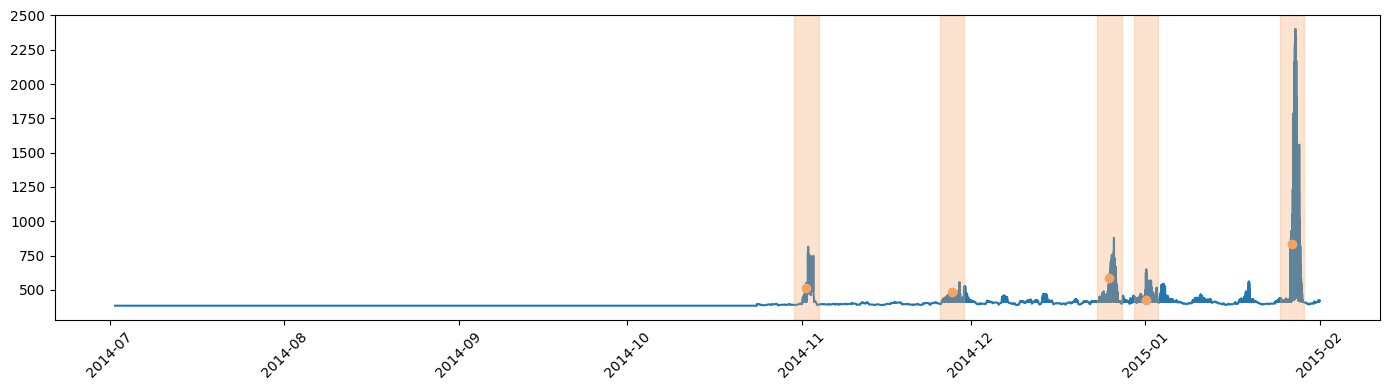

In [5]:
ldens = gs_kde.score_samples(wdata)
signal = pd.Series(index=wdata.index, data=-ldens)
nab.plot_series(signal, labels, windows, figsize=figsize)

* The signal seems _much better_ than before (but a bit noisy)

## Threshold Optimization

**Finally, we can do threshold optimization as usual**

In [6]:
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
thr_range = np.linspace(300, 600, 100)

best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt, windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 527.2727272727273, corresponding cost: 5


Cost on the whole dataset

In [7]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 22
